## Setting

In [1]:

import os, json, hashlib, glob
from dataclasses import dataclass, asdict
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ----------------------------
# 0) Config
# ----------------------------
@dataclass
class Config:
    # Lattice
    L: int = 200
    neighborhood: str = "4"        # "4" or "8"
    include_self: bool = False

    # Dynamics
    omega: float = 0.2
    record_every: int = 1
    runs_per_setting: int = 1
    seed: int = 0

    # Initial conditions
    rho0_values: tuple = (0.1, 0.3, 0.5, 0.7, 0.9)

    # G1 scan
    G1_pairs: tuple = (
        (-0.90, 0.7),   
    )

    # G2 fixed
    D2_g: float = 1.0
    D2_r: float = 1.0

    # Feedback function selector
    feedback: str = "rho"         # f(rho) = "rho" or f(rho) = "rho2"

    # Output
    out_dir: str = "results_endogenous_lattice"
    fig_dir: str = "endogenous_lattice_images"
    chk_dir: str = "checkpoints_endogenous"
    snap_base: str = "snapshots_endogenous"

cfg = Config()

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Plot chosen G_1 pairs in dilemma space

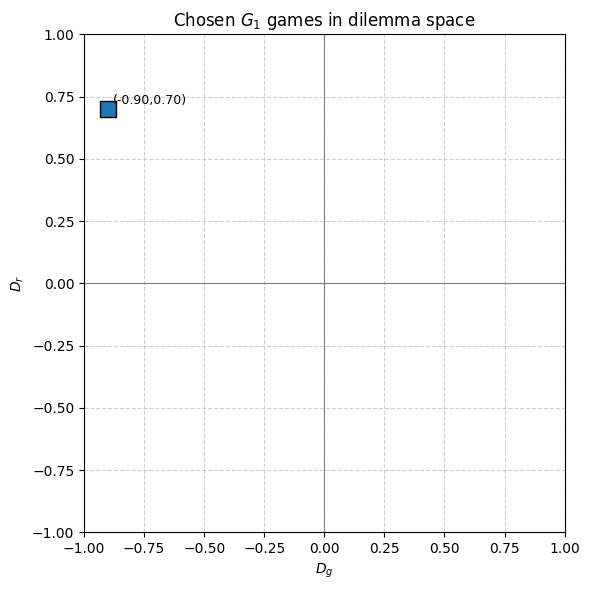

In [2]:
# ----------------------------
# Plot chosen G1 pairs in dilemma space
# ----------------------------
Dg_list = [g for (g, r) in cfg.G1_pairs]
Dr_list = [r for (g, r) in cfg.G1_pairs]

plt.figure(figsize=(6, 6))
plt.scatter(Dg_list, Dr_list, s=120, marker="s", edgecolor="black")

plt.axhline(0, color="gray", lw=0.8)
plt.axvline(0, color="gray", lw=0.8)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid(True, linestyle="--", alpha=0.6)

plt.xlabel(r"$D_g$")
plt.ylabel(r"$D_r$")
plt.title("Chosen $G_1$ games in dilemma space")

# Optional: annotate each point with its (Dg, Dr)
for (Dg, Dr) in cfg.G1_pairs:
    plt.text(Dg + 0.02, Dr + 0.02, f"({Dg:.2f},{Dr:.2f})", fontsize=9)

plt.tight_layout()
plt.show()


## Neighbourhood

In [ ]:
def get_offsets(kind: str):  # Returns the coordinate offsets defining either the 4-neighbor (von Neumann) or 8-neighbor (Moore) interaction structure on the lattice.
    if kind == "4":
        return [(-1,0),(1,0),(0,-1),(0,1)]
    if kind == "8":
        return [(-1,0),(1,0),(0,-1),(0,1),
                (-1,-1),(-1,1),(1,-1),(1,1)]
    raise ValueError("neighborhood must be '4' or '8'")

OFFSETS = get_offsets(cfg.neighborhood)

# Strategy encoding: 0=Cooperate, 1=Defect
C, D = 0, 1



## Game + feedback

In [12]:
def G_from_D(D_g: float, D_r: float) -> np.ndarray: # Constructs the 2×2 payoff matrix from the dilemma strength parameters 
    return np.array([[1.0, -float(D_r)],
                     [1.0 + float(D_g), 0.0]], dtype=np.float64)

def f_rho(rho: float) -> float: # Defines the endogenous feedback function f(rho), selecting either linear (rho) or quadratic (rho^2) dependence.
    if cfg.feedback == "rho2":
        return rho**2
    elif cfg.feedback == "rho":
        return rho
    else:
        raise ValueError("Unknown feedback type")


def G_mix(rho: float, D1_g: float, D1_r: float) -> np.ndarray: # Returns the mixed payoff matrix G(rho) as a convex combination of G1 and G2,
                                                               # weighted by the endogenous feedback function f(rho).
    G1 = G_from_D(D1_g, D1_r)
    G2 = G_from_D(cfg.D2_g, cfg.D2_r)
    a = f_rho(rho)
    return (1.0 - a) * G1 + a * G2

def fermi_prob(payoff_m: float, payoff_f: float) -> float: # Computes the Fermi imitation probability based on payoff difference and selection intensity omega.
    return 1.0 / (1.0 + np.exp(-cfg.omega * (payoff_m - payoff_f)))

## Initialisation + Update

In [13]:
def init_lattice(rng: np.random.Generator, rho0: float) -> np.ndarray: # Initializes the lattice with cooperators and defectors according to the initial cooperation density rho0.
    return rng.choice([C, D], size=(cfg.L, cfg.L), p=[rho0, 1.0 - rho0]).astype(np.int8)

def site_payoff(latt: np.ndarray, i: int, j: int, G: np.ndarray) -> float: # Computes the payoff of a single site by summing interactions
                                                                           # with its neighbors (and optionally itself) using periodic boundaries.
    s = int(latt[i, j])
    p = 0.0

    if cfg.include_self:
        p += G[s, s]

    L = cfg.L
    for di, dj in OFFSETS:
        ni, nj = (i + di) % L, (j + dj) % L
        p += G[s, int(latt[ni, nj])]
    return p

def elementary_update_endogenous(latt: np.ndarray, rng: np.random.Generator, nC: int,
                                D1_g: float, D1_r: float) -> int:      # Performs one stochastic imitation step with endogenous feedback: selects a random pair of neighbors,
                                                                       # computes payoffs using G(rho), and updates the strategy via the Fermi rule while adjusting nC.
    L = cfg.L
    i = int(rng.integers(0, L))
    j = int(rng.integers(0, L))

    di, dj = OFFSETS[int(rng.integers(0, len(OFFSETS)))]
    ni, nj = (i + di) % L, (j + dj) % L

    # endogenous G based on current rho
    rho = nC / (L * L)
    G = G_mix(rho, D1_g, D1_r)

    pi_X = site_payoff(latt, i, j, G)
    pi_Y = site_payoff(latt, ni, nj, G)

    # X imitates Y with Fermi probability
    if rng.random() < fermi_prob(pi_Y, pi_X):
        old_s = latt[i, j]
        new_s = latt[ni, nj]
        if new_s != old_s:
            latt[i, j] = new_s
            if old_s == C and new_s == D:
                nC -= 1
            elif old_s == D and new_s == C:
                nC += 1

    return nC

def mcs_endogenous(latt: np.ndarray, rng: np.random.Generator, nC: int,
                  D1_g: float, D1_r: float) -> int:                           # Performs one Monte Carlo sweep (L^2 elementary updates)
                                                                              # using endogenous dynamics and returns the updated number of cooperators.
    for _ in range(cfg.L * cfg.L):
        nC = elementary_update_endogenous(latt, rng, nC, D1_g, D1_r)
    return nC


## Checkpoint

In [14]:
def save_checkpoint(path, latt, nC, sweep, rng):    # Saves the current simulation state (lattice, cooperator count,
                                                    # sweep index, and RNG state) to allow restarting from this point.
    os.makedirs(os.path.dirname(path), exist_ok=True)
    np.savez(
        path,
        latt=latt,
        nC=int(nC),
        sweep=int(sweep),
        rng_state=rng.bit_generator.state
    )

def load_checkpoint(path, rng): # Loads a saved simulation state and restores the RNG state, returning the lattice, cooperator count, and sweep index.
    chk = np.load(path, allow_pickle=True)
    rng.bit_generator.state = chk["rng_state"].item()
    return chk["latt"], int(chk["nC"]), int(chk["sweep"])


## Append Results

In [15]:
def safe_tag(x):
    return str(x).replace(".", "p").replace("-", "m")

def results_paths(D1_g, D1_r, rho0, r): # Builds the output folder structure for a given (G1, rho0, run), ensuring it exists and returning paths for results and metadata files.
    base = f"D1g_{safe_tag(D1_g)}_D1r_{safe_tag(D1_r)}_rho0_{safe_tag(rho0)}_run_{r}"
    folder = os.path.join(cfg.out_dir, base)
    os.makedirs(folder, exist_ok=True)
    return (
        folder,
        os.path.join(folder, "results.npz"),
        os.path.join(folder, "metadata.json"),
    )

def append_series(save_npz, save_meta, rho_new, Dg_new, Dr_new, meta_update: dict, start_fresh=False): # Appends new time series data (rho, Dg, Dr) to existing results
                                                                                                       # or overwrites them if starting fresh, then updates metadata.
    if (not start_fresh) and os.path.exists(save_npz):
        with np.load(save_npz, allow_pickle=True) as old:
            rho_all = np.concatenate([old["rho_series"], rho_new])
            Dg_all  = np.concatenate([old["Dg_series"],  Dg_new])
            Dr_all  = np.concatenate([old["Dr_series"],  Dr_new])
    else:
        rho_all, Dg_all, Dr_all = rho_new, Dg_new, Dr_new

    # Windows-safe overwrite: write temp then replace
    tmp = save_npz + ".tmp.npz"
    np.savez_compressed(tmp, rho_series=rho_all, Dg_series=Dg_all, Dr_series=Dr_all)
    os.replace(tmp, save_npz)

    meta = meta_update
    meta["recorded_points_total"] = int(len(rho_all))
    with open(save_meta, "w", encoding="utf-8") as f:
        json.dump(meta, f, indent=2, sort_keys=True)



## One Run Definition

In [16]:
# Runs one endogenous-feedback lattice simulation for a given (G1, rho0):
# loads/resumes from a checkpoint or initialises a new lattice, then iterates for extra_sweeps,
# saving snapshots and checkpoints at set intervals and recording rho(t), Dg(t), Dr(t) to return.

def run_once_lattice_endogenous(
    rho0, D1_g, D1_r,
    seed_offset=0,
    checkpoint_path=None,
    checkpoint_every=50,
    snap_every=50,
    snap_dir=None,
    extra_sweeps=0,
):
    rng = np.random.default_rng(cfg.seed + seed_offset)

    if snap_dir:
        os.makedirs(snap_dir, exist_ok=True)
    
    # this part decides whether the simulation resumes from a previous checkpoint or starts from scratch
    resumed = False # default assumption

    if checkpoint_path and os.path.exists(checkpoint_path):  # it checks two things: a checkpoint path was provided and that it exists on disk
        latt, nC, start_sweep = load_checkpoint(checkpoint_path, rng)
        resumed = True
    else:
        latt = init_lattice(rng, rho0)
        nC = int(np.sum(latt == C))
        start_sweep = 0
        if checkpoint_path:
            save_checkpoint(checkpoint_path, latt, nC, start_sweep, rng)

    # ---- initial snapshot at start_sweep (only if missing) ----
    if snap_dir:
        init_snap = os.path.join(snap_dir, f"snap_{start_sweep:07d}.png")
        if not os.path.exists(init_snap):
            plt.imsave(init_snap, latt, vmin=0, vmax=1, cmap="gray")

    rho_series, Dg_series, Dr_series = [], [], []
    end_sweep = start_sweep + int(extra_sweeps)
    L2 = cfg.L * cfg.L

    # =========================================================
    # Record the initial state (t = start_sweep)
    # =========================================================
    rho = nC / L2
    G = G_mix(rho, D1_g, D1_r)
    Dg = float(G[1, 0] - 1.0)
    Dr = float(-G[0, 1])

    rho_series.append(rho)
    Dg_series.append(Dg)
    Dr_series.append(Dr)

    # ---- resume from next sweep (avoid overwriting start_sweep files) ----
    for sweep_idx in range(start_sweep + 1, end_sweep + 1):
        nC = mcs_endogenous(latt, rng, nC, D1_g, D1_r)

        # snapshots
        if snap_dir and (sweep_idx % snap_every == 0):
            plt.imsave(
                os.path.join(snap_dir, f"snap_{sweep_idx:07d}.png"),
                latt, vmin=0, vmax=1, cmap="gray"
            )

        # checkpoints
        if checkpoint_path and (sweep_idx % checkpoint_every == 0):
            save_checkpoint(checkpoint_path, latt, nC, sweep_idx, rng)

        # record series every record_every sweeps
        if sweep_idx % cfg.record_every == 0:
            rho = nC / L2
            G = G_mix(rho, D1_g, D1_r)
            Dg = float(G[1, 0] - 1.0)
            Dr = float(-G[0, 1])

            rho_series.append(rho)
            Dg_series.append(Dg)
            Dr_series.append(Dr)

    # ---- always save final checkpoint ----
    if checkpoint_path:
        save_checkpoint(checkpoint_path, latt, nC, end_sweep, rng)

    return (np.array(rho_series, dtype=np.float64),
            np.array(Dg_series, dtype=np.float64),
            np.array(Dr_series, dtype=np.float64),
            resumed, start_sweep)


## Run Experiment

In [17]:
# Creates output folders, then loops over all G1 pairs, initial densities rho0, and runs:
# runs/resumes each simulation with checkpoints and snapshots, then saves/updates the recorded
# time series (rho, Dg, Dr) and metadata, overwriting old results only when starting fresh.

os.makedirs(cfg.out_dir, exist_ok=True)
os.makedirs(cfg.fig_dir, exist_ok=True)
os.makedirs(cfg.chk_dir, exist_ok=True)
os.makedirs(cfg.snap_base, exist_ok=True)

for (D1_g, D1_r) in cfg.G1_pairs:
    for rho0 in cfg.rho0_values:
        for r in tqdm(range(cfg.runs_per_setting),
                      desc=f"G1=({D1_g},{D1_r}) rho0={rho0}",
                      dynamic_ncols=True):

            chk = os.path.join(
                cfg.chk_dir,
                f"chk_D1g_{safe_tag(D1_g)}_D1r_{safe_tag(D1_r)}_rho0_{safe_tag(rho0)}_run_{r}.npz"
            )

            snap_dir = os.path.join(
                cfg.snap_base,
                f"D1g_{safe_tag(D1_g)}_D1r_{safe_tag(D1_r)}_rho0_{safe_tag(rho0)}_run_{r}"
            )

            rho_chunk, Dg_chunk, Dr_chunk, resumed, start_sweep = run_once_lattice_endogenous(
                rho0, D1_g, D1_r,
                seed_offset=10000 * r,
                checkpoint_path=chk,
                checkpoint_every=50,
                snap_every=20,
                snap_dir=snap_dir,
                extra_sweeps= 0
            )

            folder, save_npz, save_meta = results_paths(D1_g, D1_r, rho0, r)

            # =========================================================
            # SOLUTION 1: if resuming, drop the first point (t=start_sweep)
            # to avoid duplicating it when appending to existing results.npz
            # =========================================================
            if resumed:
                if len(rho_chunk) > 0:
                    rho_chunk = rho_chunk[1:]
                    Dg_chunk  = Dg_chunk[1:]
                    Dr_chunk  = Dr_chunk[1:]

        
            # if not resumed but old results exist, overwrite to avoid fake "restart jumps"
            start_fresh = (not resumed) and os.path.exists(save_npz)

            meta_update = {
                "model": "Endogenous-feedback lattice (G(rho) mix of G1 and G2)",
                "config": asdict(cfg),
                "G1": {"D1_g": float(D1_g), "D1_r": float(D1_r)},
                "G2": {"D2_g": float(cfg.D2_g), "D2_r": float(cfg.D2_r)},
                "rho0": float(rho0),
                "run": int(r),
                "checkpoint_path": chk,
                "snap_dir": snap_dir,
                "resumed_from_checkpoint": bool(resumed),
                "start_sweep_loaded": int(start_sweep),
                "dropped_duplicate_start_point": bool(resumed),
            }

            append_series(save_npz, save_meta, rho_chunk, Dg_chunk, Dr_chunk, meta_update, start_fresh=start_fresh)

            print("Saved:", save_npz,
                  "| resumed?", resumed,
                  "| start_sweep:", start_sweep,
                  "| dropped_first_point?", resumed)



G1=(-0.9,0.7) rho0=0.1: 100%|██████████| 1/1 [00:00<00:00, 27.07it/s]


Saved: results_endogenous_lattice\D1g_m0p9_D1r_0p7_rho0_0p1_run_0\results.npz | resumed? True | start_sweep: 1200 | dropped_first_point? True


G1=(-0.9,0.7) rho0=0.3: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Saved: results_endogenous_lattice\D1g_m0p9_D1r_0p7_rho0_0p3_run_0\results.npz | resumed? True | start_sweep: 1200 | dropped_first_point? True


G1=(-0.9,0.7) rho0=0.5: 100%|██████████| 1/1 [00:00<00:00, 14.80it/s]


Saved: results_endogenous_lattice\D1g_m0p9_D1r_0p7_rho0_0p5_run_0\results.npz | resumed? True | start_sweep: 1200 | dropped_first_point? True


G1=(-0.9,0.7) rho0=0.7:   0%|          | 0/1 [00:00<?, ?it/s]

Saved: results_endogenous_lattice\D1g_m0p9_D1r_0p7_rho0_0p7_run_0\results.npz | resumed? True | start_sweep: 1200 | dropped_first_point? True


G1=(-0.9,0.7) rho0=0.9: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]

Saved: results_endogenous_lattice\D1g_m0p9_D1r_0p7_rho0_0p9_run_0\results.npz | resumed? True | start_sweep: 1200 | dropped_first_point? True


# Plotting

## Function Definition

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import imageio.v2 as imageio

def plot_cooperation(results_npz, title=None, save_path=None):
    data = np.load(results_npz, allow_pickle=True)
    rho = data["rho_series"]

    plt.figure(figsize=(10,6))
    plt.plot(rho, lw=2)
    plt.xlabel("Monte Carlo Sweeps")
    plt.ylabel(r"$\rho$")
    plt.ylim(0, 1)
    plt.grid(True)
    if title:
        plt.title(title)
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300)
        print("Saved:", os.path.abspath(save_path))

    plt.show()

def plot_dilemma_trajectory(results_npz, title="Trajectory in dilemma space", save_path=None):
    data = np.load(results_npz, allow_pickle=True)
    Dg = data["Dg_series"]
    Dr = data["Dr_series"]

    plt.figure(figsize=(8,8))
    plt.plot(Dg, Dr, lw=2)

    if len(Dg) > 0:
        plt.scatter(Dg[0], Dr[0], s=60, edgecolor="black", zorder=5)   # start
        plt.scatter(Dg[-1], Dr[-1], s=60, edgecolor="black", zorder=5) # end

        if len(Dg) >= 2:
            plt.arrow(Dg[-2], Dr[-2], Dg[-1]-Dg[-2], Dr[-1]-Dr[-2],
                      shape="full", head_width=0.02, color="black",
                      length_includes_head=True)

    plt.axhline(0, color="gray", lw=0.5)
    plt.axvline(0, color="gray", lw=0.5)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.xlabel(r"$D_g$")
    plt.ylabel(r"$D_r$")
    plt.title(title)
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300)
        print("Saved:", os.path.abspath(save_path))

    plt.show()

def make_gif_from_snapshots(snap_dir, gif_path, fps=5):
    files = sorted(glob.glob(os.path.join(snap_dir, "snap_*.png")))
    if not files:
        raise FileNotFoundError(f"No snapshots found in: {snap_dir}")

    frames = [imageio.imread(f) for f in files]
    os.makedirs(os.path.dirname(gif_path), exist_ok=True)
    imageio.mimsave(gif_path, frames, fps=fps)
    print("Saved GIF:", os.path.abspath(gif_path))


### Plot cooperation over time

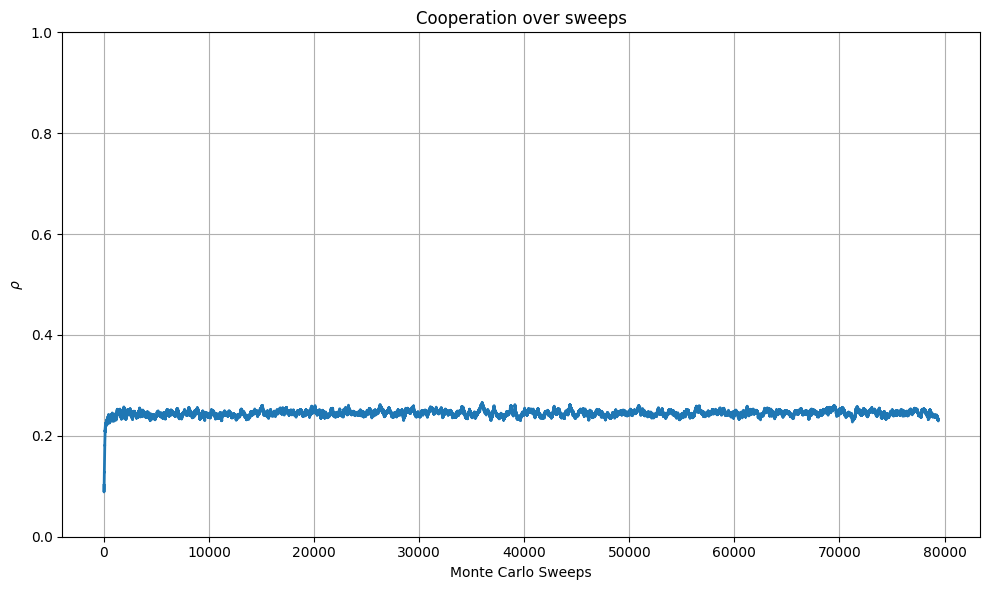

In [21]:
results_npz = "results_endogenous_lattice/D1g_m0p8_D1r_0p2_rho0_0p1_run_0/results.npz"
plot_cooperation(results_npz, title="Cooperation over sweeps")


### Plotting cooperation over time for different initial conditions

Saved to: c:\Users\HP\OneDrive\Python\master_thesis\square_lattice_with_an_endogenous_feedback\endogenous_lattice_images\cooperation_vs_MCS_G1_Dg_m0p9_Dr_0p8.png


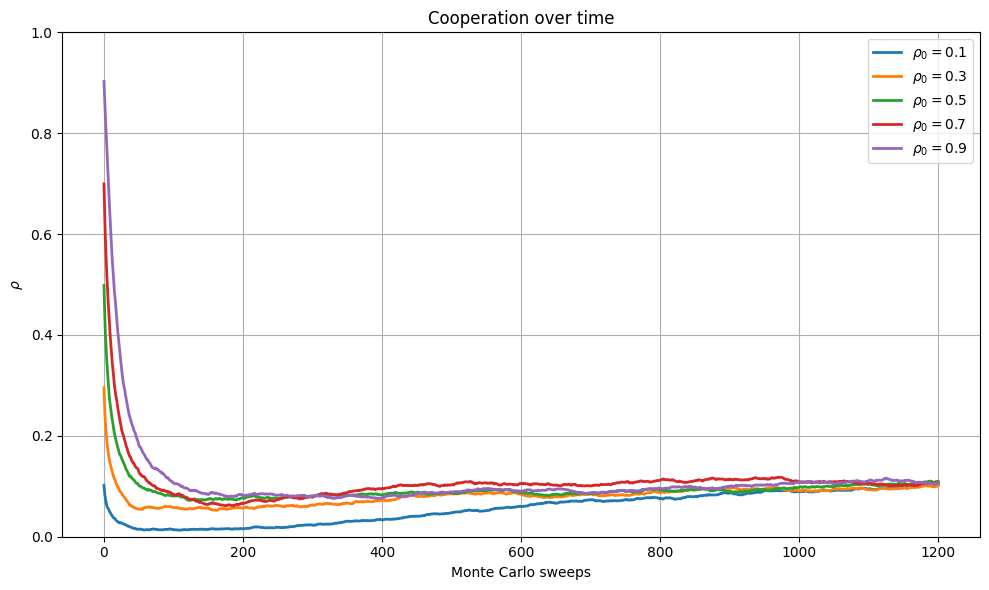

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ---------- helpers ----------
def safe_tag(x):
    return str(x).replace(".", "p").replace("-", "m")

base_dir = "results_endogenous_lattice"
save_dir = "endogenous_lattice_images"
os.makedirs(save_dir, exist_ok=True)

folders = [
    "D1g_m0p9_D1r_0p7_rho0_0p1_run_0",
    "D1g_m0p9_D1r_0p7_rho0_0p3_run_0",
    "D1g_m0p9_D1r_0p7_rho0_0p5_run_0",
    "D1g_m0p9_D1r_0p7_rho0_0p7_run_0",
    "D1g_m0p9_D1r_0p7_rho0_0p9_run_0",
]

# G1 values (used for naming)
D1_g = -0.9
D1_r = 0.8

plt.figure(figsize=(10,6))

for folder in folders:
    results_npz = os.path.join(base_dir, folder, "results.npz")

    with np.load(results_npz, allow_pickle=True) as data:
        rho = data["rho_series"]

    # Extract rho0 from folder name
    rho0 = folder.split("rho0_")[1].split("_")[0]
    rho0 = rho0.replace("p", ".").replace("m", "-")

    # Convert recorded index → Monte Carlo sweeps
    sweeps = np.arange(len(rho)) * cfg.record_every

    plt.plot(sweeps, rho, lw=2, label=f"$\\rho_0={rho0}$")

plt.xlabel("Monte Carlo sweeps")
plt.ylabel(r"$\rho$")
plt.ylim(0,1)
plt.title("Cooperation over time")
plt.grid(True)
plt.legend()
plt.tight_layout()

# ---------- save ----------
fname = (
    f"cooperation_vs_MCS_"
    f"G1_Dg_{safe_tag(D1_g)}_Dr_{safe_tag(D1_r)}.png"
)

save_path = os.path.join(save_dir, fname)
#plt.savefig(save_path, dpi=300)
print("Saved to:", os.path.abspath(save_path))

plt.show()



## Comparison with the result predicted by the Replicator Equation

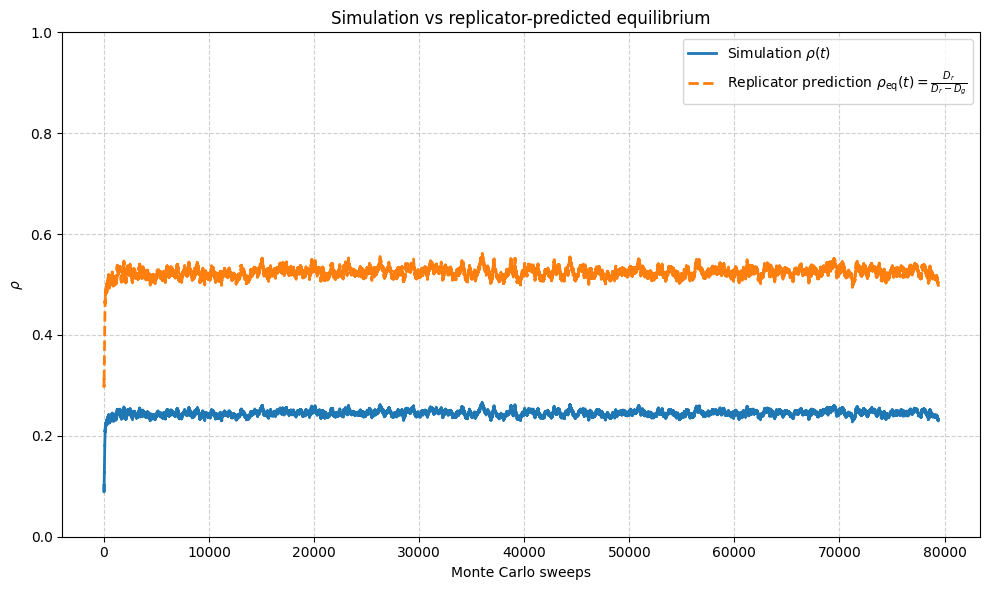

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ---- choose your run ----
results_npz = "results_endogenous_lattice/D1g_m0p8_D1r_0p2_rho0_0p1_run_0/results.npz"

with np.load(results_npz, allow_pickle=True) as data:
    rho = data["rho_series"]
    Dg  = data["Dg_series"]
    Dr  = data["Dr_series"]

# ---- Monte Carlo sweep axis ----
# If you recorded every sweep, record_every=1, this is just 0..T-1
record_every = cfg.record_every  # or set manually if needed
sweeps = np.arange(len(rho)) * record_every

# ---- replicator-predicted equilibrium at each time ----
den = (Dr - Dg)
rho_eq = np.full_like(rho, np.nan, dtype=float)

mask = np.abs(den) > 1e-12
rho_eq[mask] = Dr[mask] / den[mask]

# optional: clip to [0,1] (replicator equilibrium outside is not physical)
rho_eq = np.clip(rho_eq, 0.0, 1.0)

# ---- plot ----
plt.figure(figsize=(10, 6))
plt.plot(sweeps, rho, lw=2, label=r"Simulation $\rho(t)$")
plt.plot(sweeps, rho_eq, lw=2, linestyle="--", label=r"Replicator prediction $\rho_{\mathrm{eq}}(t)=\frac{D_r}{D_r-D_g}$")

plt.xlabel("Monte Carlo sweeps")
plt.ylabel(r"$\rho$")
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.title("Simulation vs replicator-predicted equilibrium")
plt.legend()
plt.tight_layout()
plt.show()


## Comparing the results in a small window

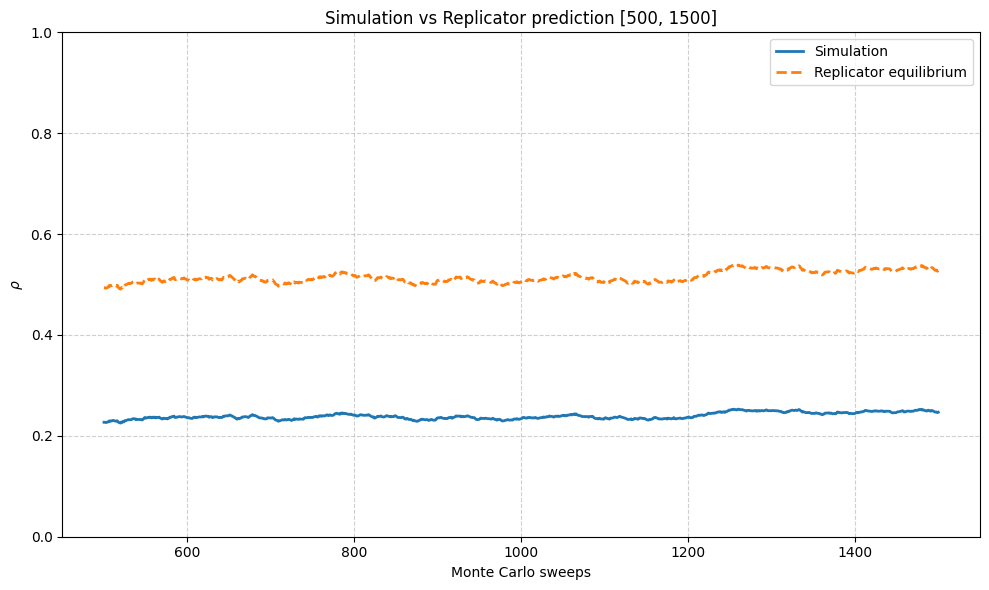

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1) Select results file
# ------------------------------
results_npz = "results_endogenous_lattice/D1g_m0p8_D1r_0p2_rho0_0p1_run_0/results.npz"

# ------------------------------
# 2) Load data
# ------------------------------
with np.load(results_npz, allow_pickle=True) as data:
    rho = data["rho_series"]
    Dg  = data["Dg_series"]
    Dr  = data["Dr_series"]

# ------------------------------
# 3) Sweep axis
# ------------------------------
record_every = 1   # change if needed
sweeps = np.arange(len(rho)) * record_every

# ------------------------------
# 4) Compute theoretical rho_eq
# ------------------------------
den = Dr - Dg
rho_eq = np.full_like(rho, np.nan, dtype=float)

valid = np.abs(den) > 1e-12
rho_eq[valid] = Dr[valid] / den[valid]
rho_eq = np.clip(rho_eq, 0.0, 1.0)

# ------------------------------
# 5) Choose window
# ------------------------------
t0 = 500
t1 = 1500

mask = (sweeps >= t0) & (sweeps <= t1)

# ------------------------------
# 6) Plot both curves
# ------------------------------
plt.figure(figsize=(10,6))

plt.plot(sweeps[mask], rho[mask],
         lw=2, label="Simulation")

plt.plot(sweeps[mask], rho_eq[mask],
         lw=2, linestyle="--", label="Replicator equilibrium")

plt.xlabel("Monte Carlo sweeps")
plt.ylabel(r"$\rho$")
plt.title(f"Simulation vs Replicator prediction [{t0}, {t1}]")
plt.ylim(0,1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()


## Comparing the results on a small region shifting the replicator equation prediction 

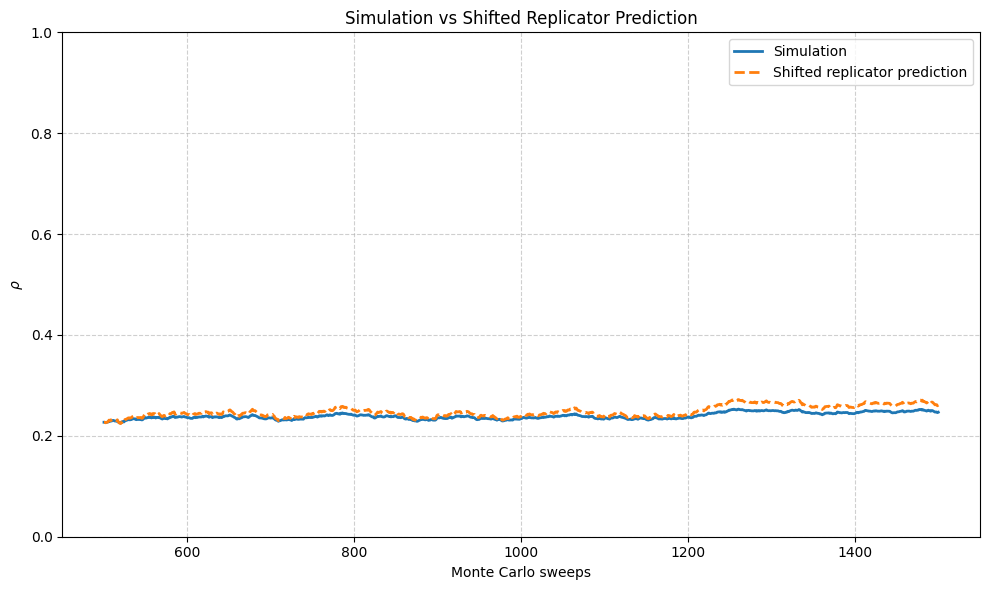

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1) Select results file
# ------------------------------
results_npz = "results_endogenous_lattice/D1g_m0p8_D1r_0p2_rho0_0p1_run_0/results.npz"

# ------------------------------
# 2) Load data
# ------------------------------
with np.load(results_npz, allow_pickle=True) as data:
    rho = data["rho_series"]
    Dg  = data["Dg_series"]
    Dr  = data["Dr_series"]

record_every = 1
sweeps = np.arange(len(rho)) * record_every

# ------------------------------
# 3) Replicator equilibrium
# ------------------------------
den = Dr - Dg
rho_eq = np.full_like(rho, np.nan, dtype=float)

valid = np.abs(den) > 1e-12
rho_eq[valid] = Dr[valid] / den[valid]
rho_eq = np.clip(rho_eq, 0.0, 1.0)

# ------------------------------
# 4) Choose window
# ------------------------------
t0 = 500
t1 = 1500

mask = (sweeps >= t0) & (sweeps <= t1)

# ------------------------------
# 5) Compute initial difference in window
# ------------------------------
first_index = np.where(mask)[0][0]

initial_difference = rho[first_index] - rho_eq[first_index]

# Shift theoretical curve
rho_eq_shifted = rho_eq + initial_difference

# ------------------------------
# 6) Plot
# ------------------------------
plt.figure(figsize=(10,6))

plt.plot(sweeps[mask], rho[mask],
         lw=2, label="Simulation")

plt.plot(sweeps[mask], rho_eq_shifted[mask],
         lw=2, linestyle="--",
         label="Shifted replicator prediction")

plt.xlabel("Monte Carlo sweeps")
plt.ylabel(r"$\rho$")
plt.title("Simulation vs Shifted Replicator Prediction")
plt.ylim(0,1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()


## Plotting the difference between the replicator equation predictions and the results of the simulation

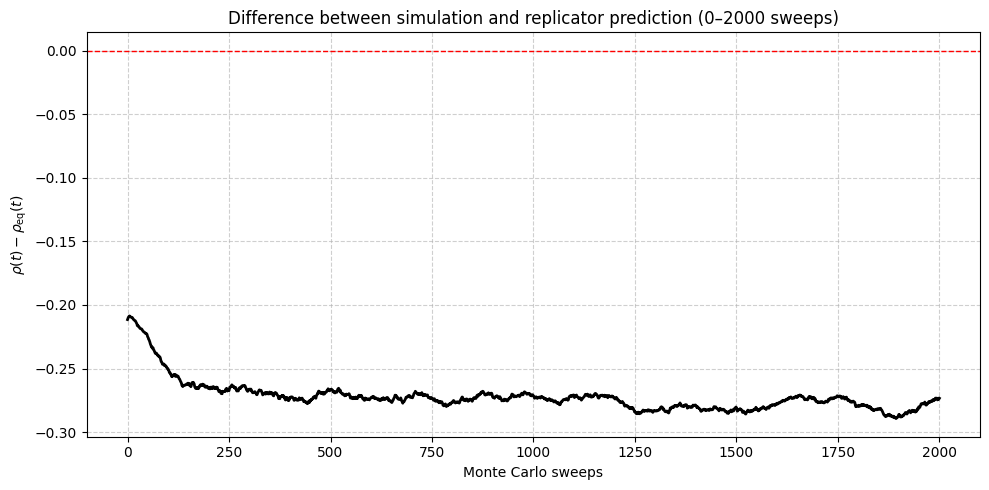

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1) Select results file
# ------------------------------
results_npz = "results_endogenous_lattice/D1g_m0p8_D1r_0p2_rho0_0p1_run_0/results.npz"

# ------------------------------
# 2) Load data
# ------------------------------
with np.load(results_npz, allow_pickle=True) as data:
    rho = data["rho_series"]
    Dg  = data["Dg_series"]
    Dr  = data["Dr_series"]

# ------------------------------
# 3) Build sweep axis
# ------------------------------
record_every = 1   # change if different
sweeps = np.arange(len(rho)) * record_every

# ------------------------------
# 4) Compute replicator equilibrium
# ------------------------------
den = (Dr - Dg)

rho_eq = np.full_like(rho, np.nan, dtype=float)
mask_valid = np.abs(den) > 1e-12
rho_eq[mask_valid] = Dr[mask_valid] / den[mask_valid]

# clip to physical region
rho_eq = np.clip(rho_eq, 0.0, 1.0)

# ------------------------------
# 5) Compute difference
# ------------------------------
diff = rho - rho_eq

# ------------------------------
# 6) Optional zoom window
# ------------------------------
t0 = 0        # start sweep
t1 = 2000     # end sweep

mask = (sweeps >= t0) & (sweeps <= t1)

# ------------------------------
# 7) Plot difference
# ------------------------------
plt.figure(figsize=(10,5))

plt.plot(sweeps[mask], diff[mask], lw=2, color="black")

plt.axhline(0, color="red", lw=1, linestyle="--")

plt.xlabel("Monte Carlo sweeps")
plt.ylabel(r"$\rho(t) - \rho_{\mathrm{eq}}(t)$")
plt.title(f"Difference between simulation and replicator prediction ({t0}–{t1} sweeps)")
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


## Comparing the Results with Nowak-Ohtsuki article

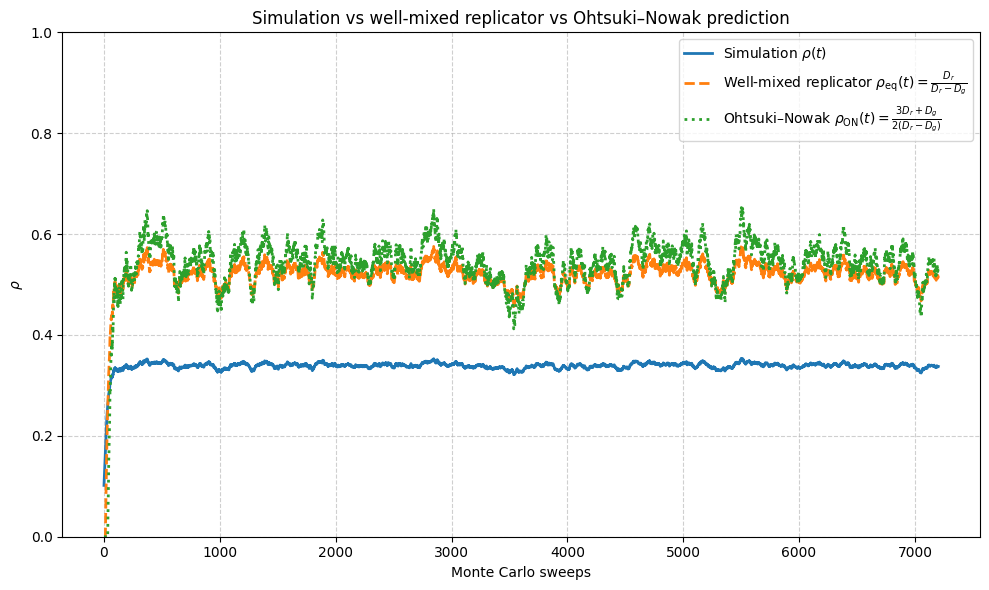

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 1) Choose your run
# ----------------------------
results_npz = "results_endogenous_lattice/D1g_m0p8_D1r_m0p2_rho0_0p1_run_0/results.npz"

with np.load(results_npz, allow_pickle=True) as data:
    rho = data["rho_series"].astype(float)
    Dg  = data["Dg_series"].astype(float)
    Dr  = data["Dr_series"].astype(float)

# ----------------------------
# 2) Time axis (Monte Carlo sweeps)
# ----------------------------
# If you don't have cfg in this notebook, set manually (e.g., record_every = 1)
try:
    record_every = cfg.record_every
except NameError:
    record_every = 1

sweeps = np.arange(len(rho)) * record_every

# ----------------------------
# 3) Theoretical curves
# ----------------------------
den = (Dr - Dg)
mask = np.abs(den) > 1e-12

# (a) Well-mixed replicator equilibrium: Dr / (Dr - Dg)
rho_rep = np.full_like(rho, np.nan, dtype=float)
rho_rep[mask] = Dr[mask] / den[mask]
rho_rep = np.clip(rho_rep, 0.0, 1.0)

# (b) Ohtsuki–Nowak curve you quoted: (3Dr + Dg) / (2(Dr - Dg))
rho_on = np.full_like(rho, np.nan, dtype=float)
rho_on[mask] = (3.0 * Dr[mask] + Dg[mask]) / (2.0 * den[mask])
rho_on = np.clip(rho_on, 0.0, 1.0)

# ----------------------------
# 4) Plot all three
# ----------------------------
plt.figure(figsize=(10, 6))
plt.plot(sweeps, rho, lw=2, label=r"Simulation $\rho(t)$")
plt.plot(sweeps, rho_rep, lw=2, ls="--",
         label=r"Well-mixed replicator $\rho_{\mathrm{eq}}(t)=\frac{D_r}{D_r-D_g}$")
plt.plot(sweeps, rho_on, lw=2, ls=":",
         label=r"Ohtsuki–Nowak $\rho_{\mathrm{ON}}(t)=\frac{3D_r+D_g}{2(D_r-D_g)}$")

plt.xlabel("Monte Carlo sweeps")
plt.ylabel(r"$\rho$")
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.title("Simulation vs well-mixed replicator vs Ohtsuki–Nowak prediction")
plt.legend()
plt.tight_layout()
#plt.savefig("endogenous_lattice_images/comparison_simulation_vs_theory.png",
           # dpi=300, bbox_inches="tight")
plt.show()



### PLotting Trajectories in the dilemma space

Saved to: c:\Users\HP\OneDrive\Python\master_thesis\square_lattice_with_an_endogenous_feedback\endogenous_lattice_images\dilemma_space_G1_Dg_m0p8_Dr_m0p5.png


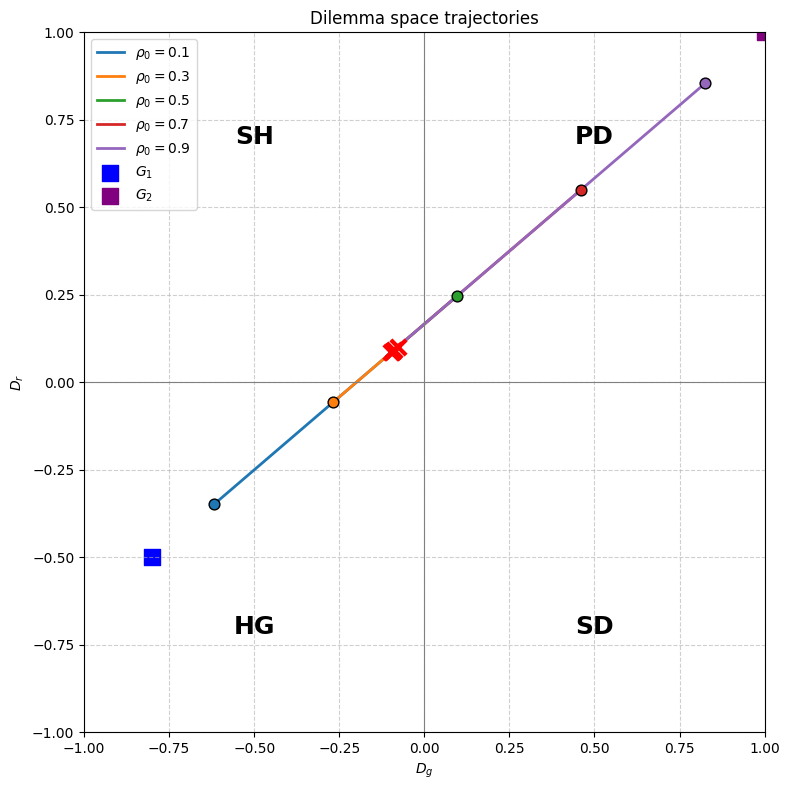

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ---------- helpers ----------
def safe_tag(x):
    return str(x).replace(".", "p").replace("-", "m")

# ---------- paths ----------
base_dir = "results_endogenous_lattice"
save_dir = "endogenous_lattice_images"
os.makedirs(save_dir, exist_ok=True)

# ---------- folders to plot ----------
folders = [
    "D1g_m0p8_D1r_m0p5_rho0_0p1_run_0",
    "D1g_m0p8_D1r_m0p5_rho0_0p3_run_0",
    "D1g_m0p8_D1r_m0p5_rho0_0p5_run_0",
    "D1g_m0p8_D1r_m0p5_rho0_0p7_run_0",
    "D1g_m0p8_D1r_m0p5_rho0_0p9_run_0",
]


# ---------- G1 and G2 values ----------
D1_g = -0.8
D1_r = -0.5
D2_g = 1.0
D2_r = 1.0

# ---------- plot ----------
plt.figure(figsize=(8, 8))

for folder in folders:
    results_npz = os.path.join(base_dir, folder, "results.npz")
    with np.load(results_npz, allow_pickle=True) as data:
        Dg = data["Dg_series"]
        Dr = data["Dr_series"]

    rho0 = folder.split("rho0_")[1].split("_")[0]
    rho0 = rho0.replace("p", ".").replace("m", "-")

    # trajectory
    plt.plot(Dg, Dr, lw=2, label=f"$\\rho_0={rho0}$")

    if len(Dg) > 0:
        # start point
        plt.scatter(Dg[0], Dr[0], s=60, edgecolor="black", zorder=5)

        # final point: red cross
        plt.scatter(Dg[-1], Dr[-1],
                    marker="x", color="red",
                    s=120, linewidths=3, zorder=6)

# Mark G1
plt.scatter(D1_g, D1_r, color="blue", marker="s", s=120, label="$G_1$")

# Mark G2
plt.scatter(D2_g, D2_r, color="purple", marker="s", s=120, label="$G_2$")

# axes and grid
plt.axhline(0, color="gray", lw=0.8)
plt.axvline(0, color="gray", lw=0.8)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid(True, linestyle="--", alpha=0.6)

# quadrant labels
plt.text(0.5, 0.7, "PD", fontsize=18, fontweight="bold", color="black",
         ha="center", va="center")

plt.text(-0.5, 0.7, "SH", fontsize=18, fontweight="bold", color="black",
         ha="center", va="center")

plt.text(0.5, -0.7, "SD", fontsize=18, fontweight="bold", color="black",
         ha="center", va="center")

plt.text(-0.5, -0.7, "HG", fontsize=18, fontweight="bold", color="black",
         ha="center", va="center")

plt.xlabel(r"$D_g$")
plt.ylabel(r"$D_r$")
plt.title("Dilemma space trajectories")
plt.legend()
plt.tight_layout()

# ---------- save with unique G1 filename ----------
fname = f"dilemma_space_G1_Dg_{safe_tag(D1_g)}_Dr_{safe_tag(D1_r)}.png"
save_path = os.path.join(save_dir, fname)
plt.savefig(save_path, dpi=300)
print("Saved to:", os.path.abspath(save_path))

plt.show()



## Plotting all Trajectories in Dilemma Space

C:\Users\HP\AppData\Local\Temp\ipykernel_19852\1284502409.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("viridis")


Saved to: c:\Users\HP\OneDrive\Python\master_thesis\square_lattice_with_an_endogenous_feedback\endogenous_lattice_images\dilemma_space_ALL_G1_colored.png


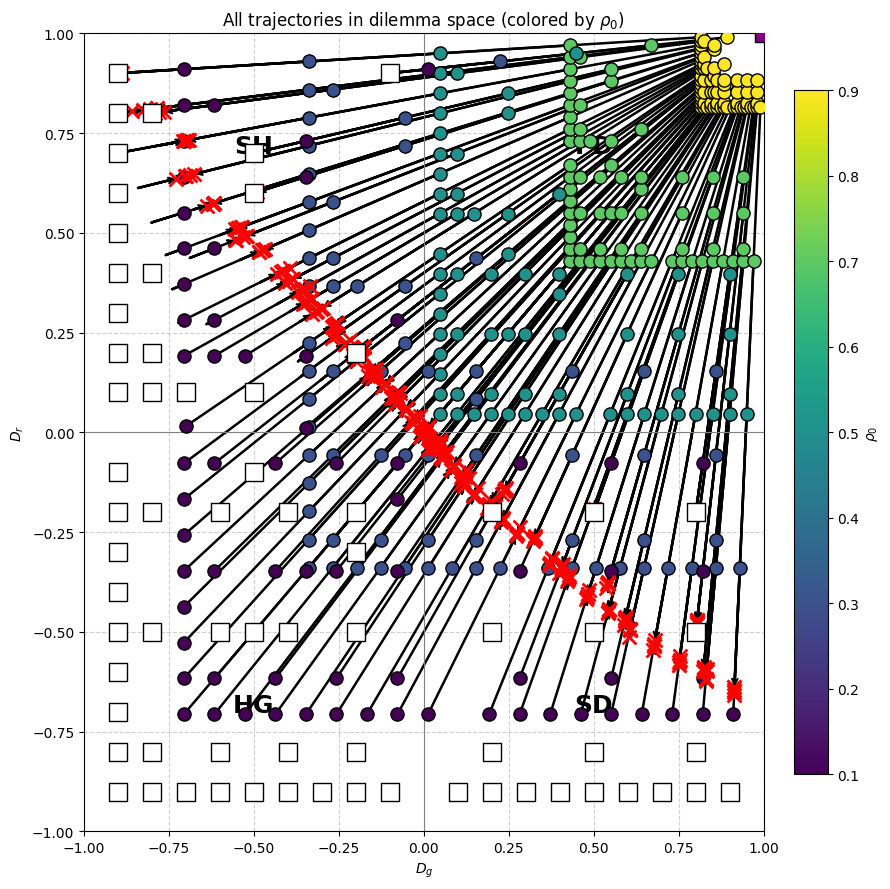

In [29]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.cm import get_cmap

base_dir = "results_endogenous_lattice"
save_dir = "endogenous_lattice_images"
os.makedirs(save_dir, exist_ok=True)

D2_g, D2_r = 1.0, 1.0

pat = re.compile(r"D1g_(?P<D1g>[mp0-9]+)_D1r_(?P<D1r>[mp0-9]+)_rho0_(?P<rho0>[mp0-9]+)_run_(?P<run>\d+)")

def tag_to_float(s):
    return float(s.replace("m", "-").replace("p", "."))

groups = defaultdict(list)
folders = sorted([f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))])

for f in folders:
    m = pat.match(f)
    if not m:
        continue
    D1g = tag_to_float(m.group("D1g"))
    D1r = tag_to_float(m.group("D1r"))
    rho0 = tag_to_float(m.group("rho0"))
    run = int(m.group("run"))
    groups[(D1g, D1r)].append((rho0, run, f))

all_rho0 = sorted({rho0 for items in groups.values() for (rho0, _, _) in items})
cmap = get_cmap("viridis")
norm = plt.Normalize(min(all_rho0), max(all_rho0))

# ---- IMPORTANT: use fig, ax so we can attach colorbar to ax ----
fig, ax = plt.subplots(figsize=(9, 9))

for (D1g, D1r), items in sorted(groups.items()):
    items = sorted(items, key=lambda x: x[0])

    for rho0, run, folder in items:
        color = cmap(norm(rho0))

        results_npz = os.path.join(base_dir, folder, "results.npz")
        if not os.path.exists(results_npz):
            continue

        with np.load(results_npz, allow_pickle=True) as data:
            Dg = data["Dg_series"]
            Dr = data["Dr_series"]

        # ---- black trajectory ----
        ax.plot(Dg, Dr, lw=1.8, color="black")

        if len(Dg) > 1:

            # initial point (colored)
            ax.scatter(Dg[0], Dr[0],
                       s=90,
                       edgecolor="black",
                       facecolor=color,
                       zorder=6)

            # final point
            ax.scatter(Dg[-1], Dr[-1],
                       marker="x",
                       color="red",
                       s=100,
                       linewidths=2,
                       zorder=7)

            # ---- arrow for direction ----
            # place arrow near end for clarity
            ax.annotate("",
                        xy=(Dg[-1], Dr[-1]),
                        xytext=(Dg[-2], Dr[-2]),
                        arrowprops=dict(
                            arrowstyle="->",
                            color="black",
                            lw=1.5
                        ))

    # mark G1
    ax.scatter(D1g, D1r,
               marker="s",
               s=160,
               edgecolor="black",
               facecolor="white",
               zorder=8)

# mark G2
ax.scatter(D2_g, D2_r,
           marker="s",
           s=180,
           edgecolor="black",
           facecolor="purple",
           zorder=9)


# axes + grid
ax.axhline(0, color="gray", lw=0.8)
ax.axvline(0, color="gray", lw=0.8)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.grid(True, linestyle="--", alpha=0.6)

# quadrant labels
ax.text(0.5, 0.7, "PD", fontsize=18, fontweight="bold", color="black", ha="center")
ax.text(-0.5, 0.7, "SH", fontsize=18, fontweight="bold", color="black", ha="center")
ax.text(0.5, -0.7, "SD", fontsize=18, fontweight="bold", color="black", ha="center")
ax.text(-0.5, -0.7, "HG", fontsize=18, fontweight="bold", color="black", ha="center")

ax.set_xlabel(r"$D_g$")
ax.set_ylabel(r"$D_r$")
ax.set_title("All trajectories in dilemma space (colored by $\\rho_0$)")

# ---- colorbar attached to ax ----
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r"$\rho_0$")

fig.tight_layout()

save_path = os.path.join(save_dir, "dilemma_space_ALL_G1_colored.png")
fig.savefig(save_path, dpi=300)
print("Saved to:", os.path.abspath(save_path))

plt.show()





## Saving Gif in a Mp4 Format

In [30]:
import os
import glob
import imageio.v2 as imageio

def save_mp4_from_snapshots(snap_dir, mp4_path, fps=12):
    files = sorted(glob.glob(os.path.join(snap_dir, "snap_*.png")))
    if not files:
        print("No snapshots found.")
        return

    os.makedirs(os.path.dirname(mp4_path), exist_ok=True)

    with imageio.get_writer(mp4_path, fps=fps, codec="libx264") as writer:
        for f in files:
            frame = imageio.imread(f)
            writer.append_data(frame)

    print("MP4 saved to:", os.path.abspath(mp4_path))


In [31]:
snap_dir = "snapshots_endogenous/D1g_m0p8_D1r_0p2_rho0_0p1_run_0"

mp4_path = "endogenous_lattice_images/lattice_D1g_m0p8_D1r_0p2_rho0_0p1.mp4"

save_mp4_from_snapshots(snap_dir, mp4_path, fps=12)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 200) to (208, 208) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


MP4 saved to: c:\Users\HP\OneDrive\Python\master_thesis\square_lattice_with_an_endogenous_feedback\endogenous_lattice_images\lattice_D1g_m0p8_D1r_0p2_rho0_0p1.mp4


## Removing some snapshots

In [129]:
import os
import glob

snap_dir = "snapshots_endogenous/D1g_m0p8_D1r_0p2_rho0_0p1_run_0"

files = sorted(glob.glob(os.path.join(snap_dir, "snap_*.png")))

removed = 0
kept = 0

for f in files:
    # extract sweep number
    name = os.path.basename(f)
    sweep = int(name.split("_")[1].split(".")[0])

    if sweep % 50 != 0:
        os.remove(f)
        removed += 1
    else:
        kept += 1

print("Kept:", kept)
print("Removed:", removed)


Kept: 165
Removed: 36


## Measuring the perimeter of cooperator clusters

Found snapshots: 1589


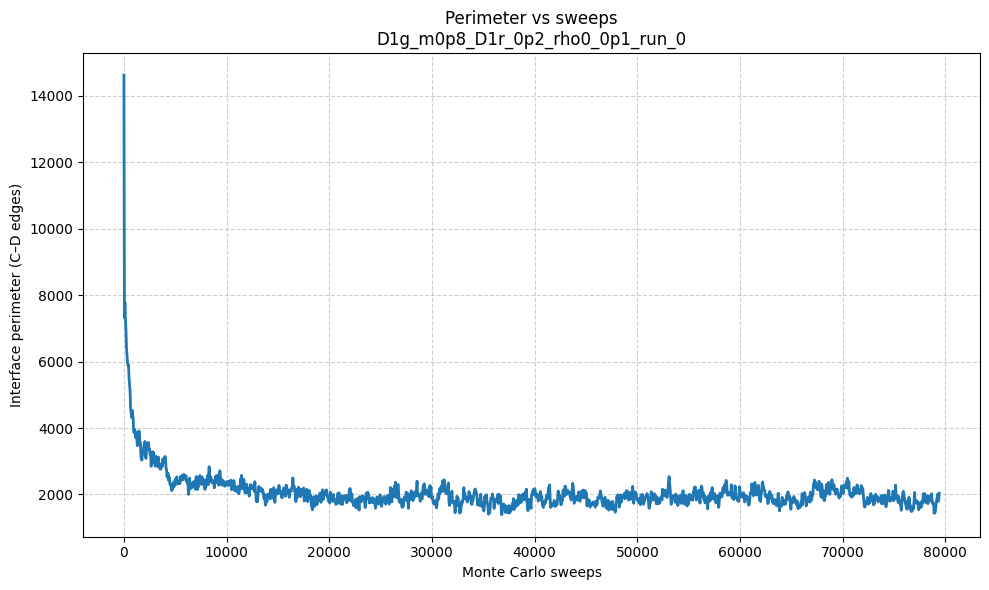

Saved figure: analysis_figures\perimeter_vs_sweeps_D1g_m0p8_D1r_0p2_rho0_0p1_run_0.png
Saved data: analysis_data\perimeter_series_D1g_m0p8_D1r_0p2_rho0_0p1_run_0.npz


In [29]:
import os, glob, re
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 1) CHANGE ONLY THIS
# ============================================================
run_name = "D1g_m0p8_D1r_0p2_rho0_0p1_run_0"
snap_base = "snapshots_endogenous"

# ============================================================
# 2) Automatic paths
# ============================================================
snap_dir = os.path.join(snap_base, run_name)
pattern = os.path.join(snap_dir, "snap_*.png")
files = sorted(glob.glob(pattern))

if not files:
    raise FileNotFoundError(f"No snapshots found in: {snap_dir}")

print("Found snapshots:", len(files))

# ============================================================
# 3) Helpers
# ============================================================
snap_re = re.compile(r"snap_(\d+)\.png$")

def sweep_from_filename(path):
    return int(snap_re.search(os.path.basename(path)).group(1))

def load_lattice(path):
    img = plt.imread(path)
    if img.ndim == 3:
        img = img[..., 0]

    binary = (img > 0.5).astype(np.uint8)
    C_mask = (binary == 0)

    # auto-flip safeguard
    rho = C_mask.mean()
    if rho < 0.01 or rho > 0.99:
        C_mask = ~C_mask

    return C_mask

def perimeter_C(C_mask):
    C = C_mask.astype(np.uint8)

    right = np.roll(C, -1, axis=1)
    down  = np.roll(C, -1, axis=0)

    P = np.sum(C != right) + np.sum(C != down)
    return int(P)

# ============================================================
# 4) Compute series
# ============================================================
sweeps = np.array([sweep_from_filename(f) for f in files])
Pvals  = np.zeros(len(files), dtype=int)
rhos   = np.zeros(len(files), dtype=float)

for k, f in enumerate(files):
    C_mask = load_lattice(f)
    rhos[k] = C_mask.mean()
    Pvals[k] = perimeter_C(C_mask)

order = np.argsort(sweeps)
sweeps, Pvals, rhos = sweeps[order], Pvals[order], rhos[order]

# ============================================================
# 5) Create automatic output folders
# ============================================================
fig_dir = "analysis_figures"
data_dir = "analysis_data"
os.makedirs(fig_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

# ============================================================
# 6) Plot
# ============================================================
plt.figure(figsize=(10,6))
plt.plot(sweeps, Pvals, lw=2)
plt.xlabel("Monte Carlo sweeps")
plt.ylabel("Interface perimeter (C–D edges)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.title(f"Perimeter vs sweeps\n{run_name}")
plt.tight_layout()

fig_path = os.path.join(fig_dir, f"perimeter_vs_sweeps_{run_name}.png")
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

# ============================================================
# 7) Save computed data automatically
# ============================================================
data_path = os.path.join(data_dir, f"perimeter_series_{run_name}.npz")
np.savez_compressed(data_path,
                    sweeps=sweeps,
                    perimeter=Pvals,
                    rho=rhos)

print("Saved figure:", fig_path)
print("Saved data:", data_path)

